### The purpose of this notebook is to demonstrate how to project vector embeddings into a two dimensional vector to help visualize RAG inputs and outputs.

### Used tools from a short course I took with Chroma on DeepLearning.AI
#### Course is located at: https://www.deeplearning.ai/short-courses/

In [1]:
%pip install --upgrade --quiet pypdf python-dotenv matplotlib umap-learn chromadb \
    langchain huggingface_hub sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from huggingface_hub import login
_ = load_dotenv(find_dotenv()) # read local .env file
hugging_face_access_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hugging_face_access_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/studio-lab-user/.cache/huggingface/token
Login successful


In [2]:
from embedding_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022',
    embedding_function=embedding_function)

chroma_collection.count()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


349

In [4]:
# https://pypi.org/project/umap-learn/
import umap
import numpy as np
from tqdm import tqdm

# fit a projection model to project embeddings in 
# into a lower dimensional space
# for furhter info: https://pypi.org/project/umap-learn/

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
# projects embeeding into a two dimensional vector that prserves
# the distances of the elements in the embedding query as opposed to PCA, for example,
# that selects the dimensions with highest variances.

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [7]:
# This runs a bit slow on SageMaker Lab Studio free account. 
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [06:28<00:00,  1.11s/it]


### Added the following to help with plotting. You can make it better further

In [8]:
# created this dataclass and plotting function

from dataclasses import dataclass

@dataclass
class PlotLayer:
    embedding: list
    size: int = None
    color: str = None
    facecolor: str = None
    edgecolor: str = None
    marker: str = None


import matplotlib.pyplot as plt
%matplotlib inline

def plot_projections(title, PlotLayers: list[PlotLayer]) -> None:
    plt.figure()
    for PlotLayer in PlotLayers:
        plt.scatter(PlotLayer.embedding[:, 0], PlotLayer.embedding[:, 1],
            s=PlotLayer.size, marker=PlotLayer.marker, color=PlotLayer.color,
            facecolor = PlotLayer.facecolor, edgecolor=PlotLayer.edgecolor)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.axis('off')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Here is your entire document embedding space in chroma projected into 2-d space with UMAP.

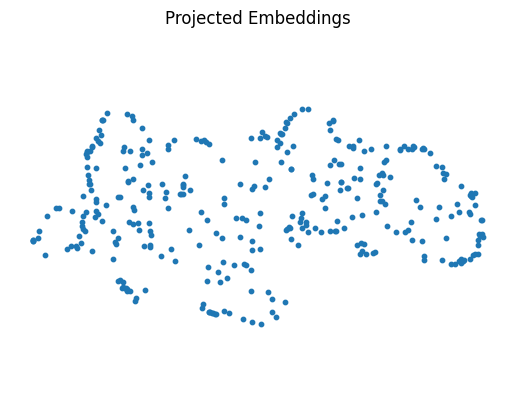

In [9]:
title = "Projected Embeddings"
PlotLayers = [PlotLayer(embedding=projected_dataset_embeddings, size=10, color=None)]

plot_projections(title, PlotLayers)

### While querying and visualizing, try to make sense of what's going on

In [10]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

In [11]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


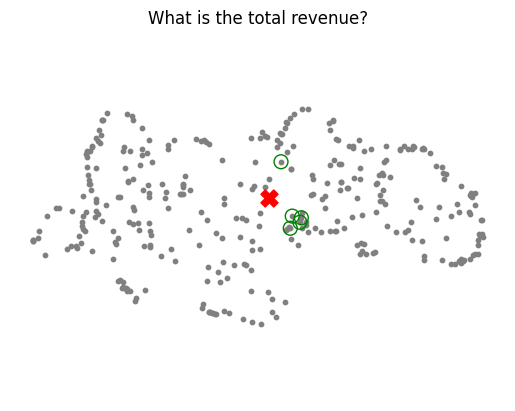

In [12]:
PlotLayers = [PlotLayer(embedding=projected_dataset_embeddings, size=10, color='gray'),
          PlotLayer(embedding=projected_query_embedding, size=150, color='red', marker="X"),
          PlotLayer(embedding=projected_retrieved_embeddings, size=100, facecolor='none', edgecolor='g')]
plot_projections(title=query, PlotLayers=PlotLayers)

In [13]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [14]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


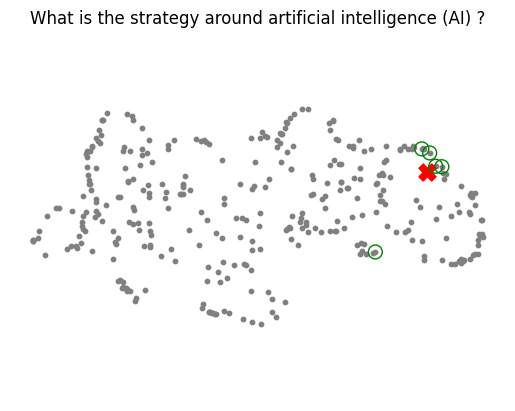

In [15]:
PlotLayers = [PlotLayer(embedding=projected_dataset_embeddings, size=10, color='gray'),
          PlotLayer(embedding=projected_query_embedding, size=150, color='red', marker="X"),
          PlotLayer(embedding=projected_retrieved_embeddings, size=100, facecolor='none', edgecolor='g')]
plot_projections(title=query, PlotLayers=PlotLayers)

### What do you think of the following query and plot?

In [16]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

18 total rewards we develop dynamic, sustainable, market - driven, and
strategic programs with the goal of providing a highly differentiated
portfolio to attract, reward, and retain top talent and enable our
employees to thrive. these programs reinforce our culture and values
such as collaboration and growth mindset. managers evaluate and
recommend rewards based on, for example, how well we leverage the work
of others and contribute to the success of our colleagues. we monitor
pay equity and career progress across multiple dimensions. as part of
our effort to promote a one microsoft and inclusive culture, in fiscal
year 2021 we expanded stock eligibility to all microsoft employees as
part of our annual rewards process. this includes all non - exempt and
exempt employees and equivalents across the globe including business
support professionals and datacenter and retail employees. in response

17 as of june 30, 2022, we employed approximately 221, 000 people on a
full - time basis, 122, 

In [17]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


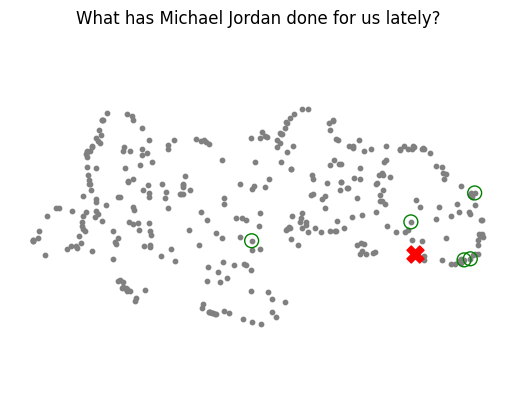

In [18]:
PlotLayers = [PlotLayer(embedding=projected_dataset_embeddings, size=10, color='gray'),
          PlotLayer(embedding=projected_query_embedding, size=150, color='red', marker="X"),
          PlotLayer(embedding=projected_retrieved_embeddings, size=100, facecolor='none', edgecolor='g')]
plot_projections(title=query, PlotLayers=PlotLayers)